In [9]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# --- Подготовка данных ---
# Загрузите edges2.csv и nodes.csv как df
edges_df = pd.read_csv("data/edges4.csv")
nodes_df = pd.read_csv("data/nodes4.csv")
resources_df = pd.read_csv("data/resources4.csv")

# Создание edge_index
sources = edges_df['source_user'].astype(int).values
targets = edges_df['target_resource'].astype(int).values
offset = sources.max() + 1
targets_shifted = targets + offset

# Кодирование признаков узлов
le = LabelEncoder()
#  Признаки Кодируем роль
nodes_df['role_encoded'] = le.fit_transform(nodes_df['role'])
# Признаки Время последнего входа → дни
nodes_df['last_login_time'] = pd.to_datetime(nodes_df['last_login_time'])
ref_date = pd.Timestamp("2025-05-07")
nodes_df['days_since_login'] = (ref_date - nodes_df['last_login_time']).dt.days
# Признаки пользователей
user_features = nodes_df[['role_encoded', 'login_count', 'access_level',
                          'session_time', 'var_activity', 'days_since_login']].values

# --- Обработка ресурсов ---
resources_df['resource_type_encoded'] = LabelEncoder().fit_transform(resources_df['resource_type'])
# Реальные признаки ресурсов
base_resource_features = resources_df[['resource_type_encoded', 'access_count_last_month',
                                       'importance', 'access_level']].values

# Дополняем признаки ресурсов двумя нулями (чтобы было 6 признаков, как у пользователей)
resource_features_padded = np.hstack([base_resource_features, np.zeros((base_resource_features.shape[0], 2))])

# Объединяем признаки пользователей и ресурсов
x_combined = np.vstack([user_features, resource_features_padded])
x = torch.tensor(x_combined, dtype=torch.float)

# Объединяем в edge_index [2, num_edges]
edge_index_np = np.vstack([sources, targets_shifted])
edge_index = torch.tensor(edge_index_np, dtype=torch.long)
y = torch.tensor(nodes_df['role_encoded'].values, dtype=torch.long)

# --- Маски ---
num_users = user_features.shape[0]
num_total = x.shape[0]
train_idx, test_idx = train_test_split(np.arange(num_users), test_size=0.3, stratify=y, random_state=42)
train_mask = torch.zeros(num_total, dtype=torch.bool)
test_mask = torch.zeros(num_total, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)


In [10]:
y

tensor([4, 0, 0, 3, 4, 2, 0, 4, 4, 1, 4, 0, 3, 1, 2, 0, 0, 0, 3, 1])

In [13]:
y.shape

torch.Size([20])

In [14]:
x.shape

torch.Size([32, 6])

In [15]:
data

Data(x=[32, 6], edge_index=[2, 100], y=[20], train_mask=[32], test_mask=[32])

In [11]:
# --- Модель ---
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

model = GCN(in_channels=6, hidden_channels=16, out_channels=len(torch.unique(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

Epoch 010, Loss: 184.9128, Test Acc: 0.3333
Epoch 020, Loss: 78.4590, Test Acc: 0.1667
Epoch 030, Loss: 32.3034, Test Acc: 0.1667
Epoch 040, Loss: 27.8073, Test Acc: 0.3333
Epoch 050, Loss: 17.3591, Test Acc: 0.1667
Epoch 060, Loss: 5.4562, Test Acc: 0.3333
Epoch 070, Loss: 4.8261, Test Acc: 0.1667
Epoch 080, Loss: 6.7401, Test Acc: 0.1667
Epoch 090, Loss: 8.5702, Test Acc: 0.1667
Epoch 100, Loss: 8.4614, Test Acc: 0.3333


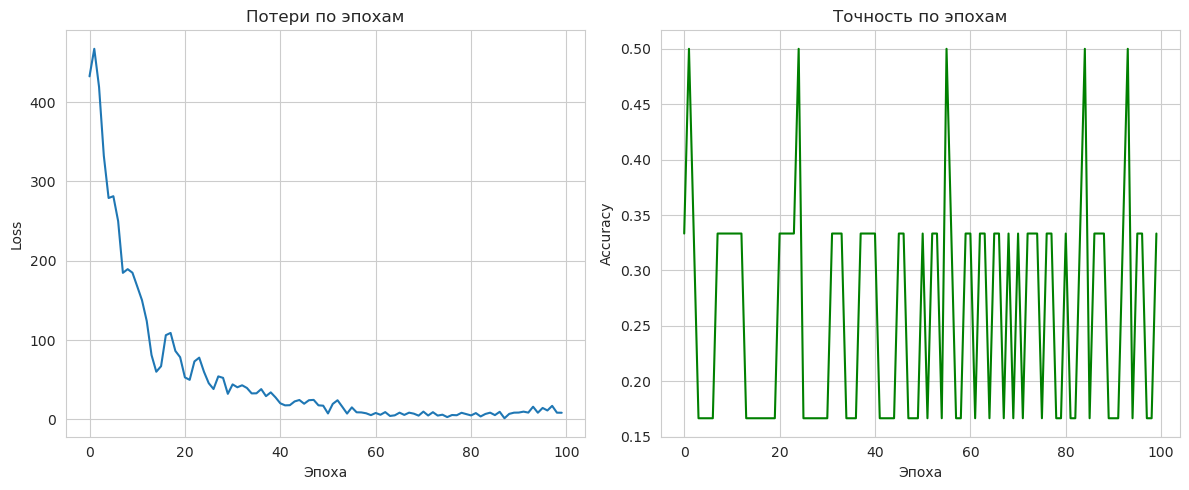

User 9: True=1 → Pred=0
User 7: True=4 → Pred=0
User 11: True=0 → Pred=0
User 12: True=3 → Pred=0
User 17: True=0 → Pred=0
User 5: True=2 → Pred=0


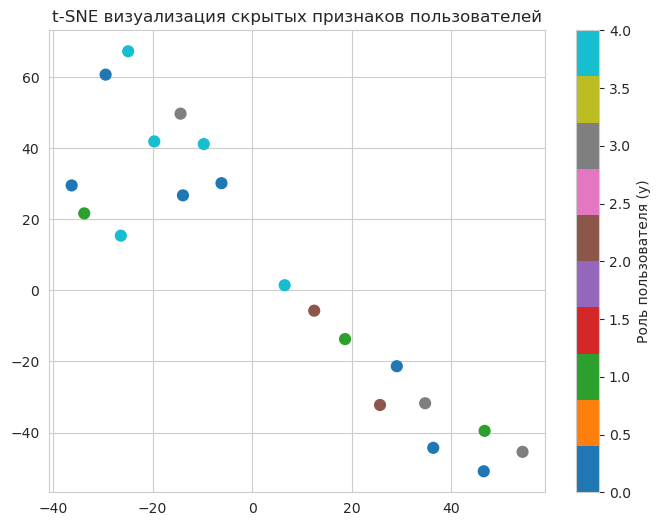

In [12]:

# --- Обучение ---
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[:num_users][train_mask[:num_users]], y[train_mask[:num_users]])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out[:num_users].argmax(dim=1)
    correct = (pred[test_mask[:num_users]] == y[test_mask[:num_users]]).sum()
    acc = int(correct) / int(test_mask[:num_users].sum())
    return acc

losses = []
accuracies = []

for epoch in range(1, 101):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")

#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

#Анализ предсказаний на тесте
model.eval()
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1)
    for idx in test_idx:
        print(f"User {idx}: True={y[idx].item()} → Pred={preds[idx].item()}")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Получим скрытые представления (после первого слоя GCN)
model.eval()
with torch.no_grad():
    x_hidden = model.conv1(data.x, data.edge_index)
    x_hidden = F.relu(x_hidden)  # [num_nodes, hidden_dim]

# Применим t-SNE только к пользователям (первые 20 узлов)
x_user = x_hidden[:num_users].cpu().numpy()
y_user = y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
x_tsne = tsne.fit_transform(x_user)

# Визуализация
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_user, cmap='tab10', s=60)
plt.title("t-SNE визуализация скрытых признаков пользователей")
plt.colorbar(scatter, label="Роль пользователя (y)")
plt.grid(True)
plt.show()

